# Projekt zaliczeniowy - modelowanie cen nieruchomości

# Wczytanie bibliotek

In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math 
import random
from string import ascii_letters

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression 
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Wczytanie danych

In [232]:
df = pd.read_csv("house_sales.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [233]:
# Zmienna sqft_living jest sumą sqft_above i sqft_basement
all(df["sqft_above"] + df["sqft_basement"] == df["sqft_living"])

True

In [234]:
# Wyrzucam niepotrzebne zmienne
df.drop(columns = ["id", "date", "zipcode"], inplace = True)

# Sprawdzam czy dane zawierają puste wartości
print("Zbiór zawiera NA") if any(df.isnull().sum() > 0) else print("Zbiór jest kompletny")

Zbiór jest kompletny


# Wizualizacja danych

In [235]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,47.560053,-122.213896,1986.552492,12768.455652
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,0.138564,0.140828,685.391304,27304.179631
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,47.777600,-121.315000,6210.000000,871200.000000


In [236]:
df.loc[df['bedrooms'] == 33, 'bedrooms'] = 3

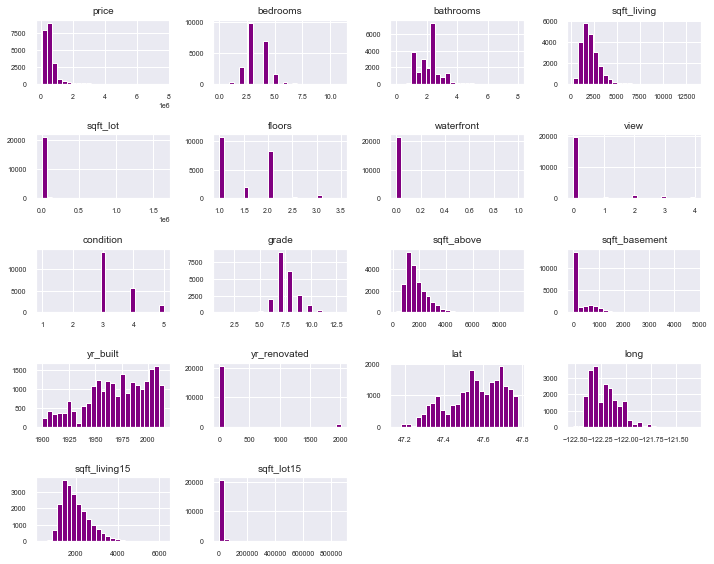

In [237]:
# Rysuję histogramy zmiennych
def DrawHistograms(df, variables, n_rows, n_cols):
    fig = plt.figure(figsize = (n_rows * 2, n_cols * 2))
    plt.rc('xtick', labelsize = 7)
    plt.rc('ytick', labelsize = 7)
    for i, var in enumerate(variables):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        df[var].hist(bins = 25, ax = ax, color = "purple")
        ax.set_title(var, fontsize = 10)
    fig.tight_layout()
    plt.show()

numerical = df.select_dtypes(include = np.number)
DrawHistograms(df, numerical, 5, 4)

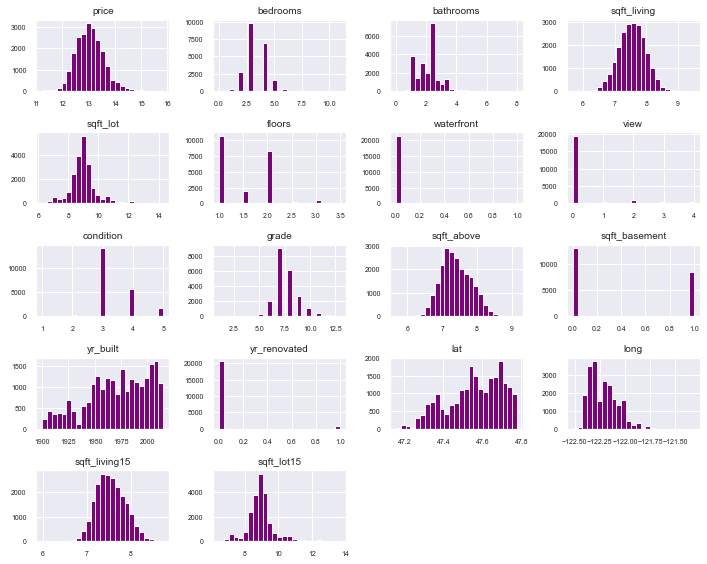

In [238]:
# Transformacja logarytmiczna
for var in ["price", "sqft_living", "sqft_above", "sqft_living15", "sqft_lot", "sqft_lot15"]:
    df[var] = np.log(df[var])
    
# Zamiana na zmienne binarne
for var in ["yr_renovated", "sqft_basement"]:
    df.loc[df[var] > 0, var] = 1
    
DrawHistograms(df, numerical, 5, 4)

<AxesSubplot:>

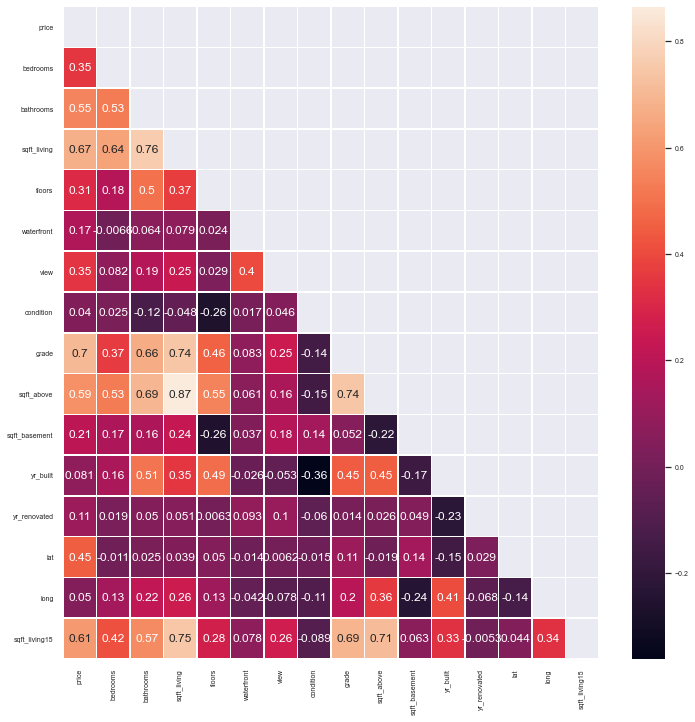

In [239]:
# Mapa korelacji
corr_matrix = df[df.columns[~df.columns.isin(['sqft_lot', 'sqft_lot15'])]].corr()
mask = np.zeros_like(corr_matrix, dtype = bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (12, 12))
sns.heatmap(corr_matrix, annot = True, linewidths = 0.5, ax = ax, mask = mask)

In [240]:
corr = corr_matrix['price'].sort_values(ascending = False)
print(corr)

price            1.000000
grade            0.703634
sqft_living      0.674913
sqft_living15    0.607187
sqft_above       0.586303
bathrooms        0.550802
lat              0.449174
bedrooms         0.350990
view             0.346522
floors           0.310558
sqft_basement    0.212437
waterfront       0.174586
yr_renovated     0.114124
yr_built         0.080655
long             0.049942
condition        0.039558
Name: price, dtype: float64


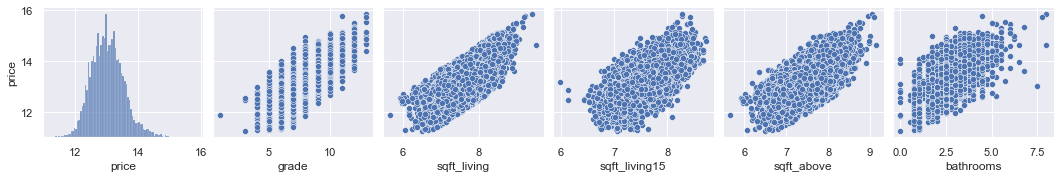

In [241]:
# Wizualizacja najsilniej skorelowanych zmiennych (>50%)
sns.set()
cols = corr[corr > 0.5].index.tolist()
sns.pairplot(df[cols], 
             y_vars = ['price'], 
             x_vars = cols.remove("price"),
             height = 2.5)
plt.show()

In [242]:
# Podział na zbiór treningowy i testowy
random.seed(12345)
target = df["price"]
df.drop(["price"], axis = 1, inplace = True)
X_train, X_test, y_train, y_test = train_test_split(df, target, random_state = 42, train_size = 0.8, shuffle = True)
X_train.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
6325,3,1.75,7.484369,9.479986,1.0,0,0,4,9,7.484369,0,1983,0,47.3670,-122.152,7.919356,9.479986
13473,2,1.00,6.907755,8.216088,1.0,0,0,3,6,6.684612,1,1929,0,47.5520,-122.290,7.146772,8.517193
17614,3,1.00,6.984716,8.920790,1.5,0,0,3,6,6.897705,1,1942,0,47.4838,-122.335,7.064759,8.961879
16970,3,2.25,7.644919,8.922658,1.0,0,0,4,7,7.154615,1,1977,0,47.3951,-122.172,7.495542,8.902456
20868,2,2.50,7.462215,7.271704,2.0,0,0,3,8,7.276556,1,2007,0,47.7043,-122.209,7.644919,9.254740


# Regresja liniowa

In [243]:
# Funkcja do miar błędów i wspołczynnika R2
def GetMetrics(real, pred):
    metrics = pd.DataFrame(columns = ["MSE", "RMSE", "MAE", "R2"])
    mse = round(mean_squared_error(real, pred), 4)
    rmse = round(math.sqrt(mse), 4)
    mae = round(np.mean(np.abs(real - pred)), 4)
    r2 = round(r2_score(real, pred), 4)
    metrics = metrics.append({"MSE":mse, "RMSE":rmse, "MAE":mae, "R2":r2}, ignore_index = True)
    return(metrics)

In [244]:
# Regresja liniowa
regression = LinearRegression(normalize = False)
regression.fit(X_train, y_train)

y_pred_test = regression.predict(X_test)
regression_metrics = GetMetrics(y_test, y_pred_test)
regression_metrics

,MSE,RMSE,MAE,R2
0,0.0648,0.2546,0.1947,0.7726


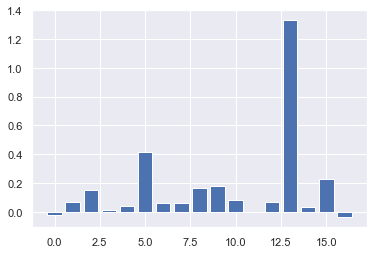

Najważniejszą zmienną jest lat


In [245]:
# Istotność zmiennych
importance = regression.coef_
index = np.argmax(importance)

plt.bar([x for x in range(len(importance))], importance)
plt.show()
print("Najważniejszą zmienną jest " + X_train.columns[index])

# Drzewa decyzyjne

In [246]:
# Drzewo losowe z domyślnymi hiperparametrami
tree = tree.DecisionTreeRegressor()
tree.fit(X_train, y_train)

y_pred_test = tree.predict(X_test)
GetMetrics(y_test, y_pred_test)

,MSE,RMSE,MAE,R2
0,0.063,0.251,0.1788,0.7791


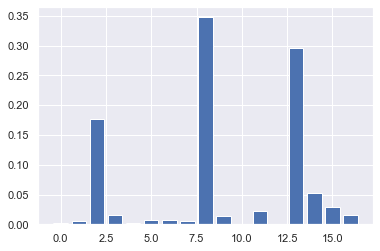

Najważniejszą zmienną jest grade


In [254]:
# Istotność zmiennych
importance = tree.feature_importances_
index = np.argmax(importance)

plt.bar([x for x in range(len(importance))], importance)
plt.show()
print("Najważniejszą zmienną jest " + X_train.columns[index])

In [248]:
# Hiperparametry
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10, 20]
min_samples_leaf = [1, 2, 4, 8]
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# Walidacja krzyżowa (wybór na podstawie R2)
tree_random = RandomizedSearchCV(estimator = tree, 
                                 param_distributions = random_grid, 
                                 n_iter = 100, cv = 3, verbose = 2, n_jobs = -1)

tree_random.fit(X_train, y_train)
print(tree_random.best_params_)
y_pred_test = tree_random.predict(X_test)

# Miary błędów
tree_metrics = GetMetrics(y_test, y_pred_test)
tree_metrics

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'auto', 'max_depth': 10}


,MSE,RMSE,MAE,R2
0,0.046,0.2145,0.1568,0.8388


# Lasy losowe

In [249]:
# Las losowy z domyślnymi hiperparametrami
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

y_pred_test = rf.predict(X_test)
GetMetrics(y_test, y_pred_test)

,MSE,RMSE,MAE,R2
0,0.0322,0.1794,0.1273,0.8872


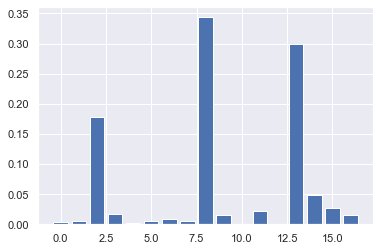

Najważniejszą zmienną jest grade


In [250]:
# Istotność zmiennych
importance = rf.feature_importances_
index = np.argmax(importance)

plt.bar([x for x in range(len(importance))], importance)
plt.show()
print("Najważniejszą zmienną jest " + X_train.columns[index])

In [251]:
rf = RandomForestRegressor()

# Hiperparametry (wybór na podstawie R2)
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
bootstrap = [True, False]
random_grid['n_estimators'] = n_estimators
random_grid['bootstrap'] = bootstrap

# Walidacja krzyżowa
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 50, cv = 3, verbose = 2, n_jobs = -1)

rf_random.fit(X_train, y_train)
print(rf_random.best_params_)
y_pred_test = rf_random.predict(X_test)

# Miary błędów
rf_metrics = GetMetrics(y_test, y_pred_test)
rf_metrics

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'n_estimators': 178, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}


,MSE,RMSE,MAE,R2
0,0.0316,0.1778,0.1267,0.889


# Porównanie modeli

In [252]:
metrics = regression_metrics.append(tree_metrics).append(rf_metrics)
metrics.index = ['Regresja liniowa', 'Drzewo losowe', 'Las losowy']
metrics

,MSE,RMSE,MAE,R2
Regresja liniowa,0.0648,0.2546,0.1947,0.7726
Drzewo losowe,0.0460,0.2145,0.1568,0.8388
Las losowy,0.0316,0.1778,0.1267,0.8890


Najlepszym modelem jest las losowy z R2 na poziomie 88.9%